<h1> Modelling and evaluation </h1>
<p> We have had difficulties with setting a random state for the XGB Classifier. Therefore the results from that model and its effect on the ensemble model will be different from each run. </p>
<h2> 1. Importing libraries and downloading datasets </h2>

In [4]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, layers, Input, callbacks
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix

# from tensorflow.keras.preprocessing.text import one_hot
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Flatten,Embedding,Dense
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.layers import Dense , Flatten ,Embedding,Input
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing all the datasets
A_tra_X = pd.read_csv('data/train_A.csv')
A_val_X = pd.read_csv('data/val_A.csv')
A_test_X = pd.read_csv('data/test_A.csv')


B_tra_X = pd.read_csv('data/train_B.csv')
B_val_X = pd.read_csv('data/val_B.csv')
B_test_X = pd.read_csv('data/test_B.csv')


C_tra_X = pd.read_csv('data/train_C.csv')
C_val_X = pd.read_csv('data/val_C.csv')
C_test_X = pd.read_csv('data/test_C.csv')


D_tra_X = pd.read_csv('data/train_D.csv')
D_val_X= pd.read_csv('data/val_D.csv')
D_test_X = pd.read_csv('data/test_D.csv')

tra_y = pd.read_csv('data/train_y.csv')
val_y = pd.read_csv('data/val_y.csv')
test_y = pd.read_csv('data/test_y.csv')

tra_y_eye = np.eye(10)[list(tra_y['0'])]
val_y_eye = np.eye(10)[list(val_y['0'])]
test_y_eye = np.eye(10)[list(test_y['0'])]

<h2> 2. Benchmarks </h2>
<h3> 2.1 Naive Benchmark, Monte Carlo Method </h3>
<p> Using 1000 simulations with random guesses on target labels. </p>

In [6]:
def naive_benchmark_MonC(y):
    accuracy_list = []
    for i in range(0,1000,1):
        naive_rand_pred = np.random.randint(0,12,size=(len(y)))
        accuracy_sel = ACC(naive_rand_pred, y)
        accuracy_list.append(accuracy_sel)
    return np.mean(accuracy_list)

In [7]:
naive_benchmark_MonC(test_y)

0.08240598290598292

<h3> 2.2 Naive Benchmark, Majority Class Method </h3>
<p> Using Frodo, which equals label 2, as guess </p>

In [8]:
def naive_benchmark_MajC(y):                
    pred_MCNB =np.repeat(2,len(y))
    return ACC(pred_MCNB, y)

In [9]:
naive_benchmark_MajC(test_y)

0.1752136752136752

<h2> 3. Modelling  </h2>
<!-- <h3> 3.1 ANN on dataset A</h3> -->
<!-- <p> Dataset A contains various numerical retrieved from the characters. </p>
<p> The feedforward neural network has a relative simple architecture. -->

<h3> 3.1 XGBC on dataset D

In [10]:
p_g = {
    'alpha': hp.uniform('alpha',0,1),
    'gamma': hp.uniform('gamma',0,9),
    'reg_lambda':hp.quniform('reg_lamda',0,3,1),
    'max_depth':hp.quniform('max_depth',6,12,1),
    'learning_rate': hp.uniform('learning_rate',0.001,0.05),
    'n_estimators': hp.quniform('n_estimators', 5,500,1),
    'min_child_weight': hp.quniform('min_child_weight',0,5,1),
    'seed':42
    }

In [11]:
def bayopt_xgb(p_g):
    internal_model = XGBClassifier(
                     objective='multi:softmax',
                     alpha=p_g['alpha'],
                     gamma=p_g['gamma'],
                     reg_lambda= p_g['reg_lambda'],
                     max_depth = int(p_g['max_depth']),
                     n_estimator = (p_g['n_estimators']),
                     learning_rate=p_g['learning_rate'],
                     min_child_weight=p_g['min_child_weight'],
                     seed =p_g['seed'],
                     )
    internal_model.set_params(random_state=42)
    internal_model.fit(D_tra_X, tra_y,
                     eval_set = [(D_val_X, val_y)],
                     eval_metric = 'mlogloss',
                     early_stopping_rounds=25,verbose=False)
    score =np.mean(cross_val_score(internal_model, D_tra_X, tra_y, scoring='accuracy', cv=3))
    print('Score:', score)
    return {'loss':-score, 'status':STATUS_OK}

def tune():
    trials = Trials()
    best_tune = fmin(fn=bayopt_xgb, 
                    space=p_g,
                    algo= tpe.suggest,
                    max_evals=10,
                    trials=trials)
    return best_tune


ntune = tune()
ntune['n_estimators'] =  int(ntune['n_estimators'])
ntune['max_depth'] =  int(ntune['max_depth'])
xmodel = XGBClassifier(**ntune)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

Score:                                                
0.23538565290099744                                   
Score:                                                                            
0.200529483867146                                                                 
Score:                                                                            
0.21447514114253688                                                               
Score:                                                                            
0.2266619277404891                                                                
Score:                                                                            
0.26937377824559483                                                               
Score:                                                                            
0.22491672704240884                                                               
Score:                                                      

In [12]:
xmodel.fit(D_tra_X, tra_y)

XGBClassifier(alpha=0.6151985549677926, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4652960563755727, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.008624755741565193,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=349, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
print('Accuracy train: ',ACC(xmodel.predict(D_tra_X),tra_y))
print('Accuracy validation: ',ACC(xmodel.predict(D_val_X),val_y))
print('Accuracy test: ',ACC(xmodel.predict(D_test_X),test_y))

Accuracy train:  0.5448997384481256
Accuracy validation:  0.30708661417322836
Accuracy test:  0.3504273504273504


<h3> 3.2 ANN on dataset A </h3>

In [14]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

ann_model = keras.Sequential([
    layers.Dense(20, activation='relu',input_dim=20),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(16, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.03)
ann_model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
              )

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=30, 
    restore_best_weights=True,
)
history = ann_model.fit(A_tra_X, tra_y_eye, 
          validation_data= (A_val_X, val_y_eye),
          epochs=150, batch_size=30, 
          callbacks=early_stopping,
          verbose=1
          )


Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1130 - loss: 2.3646 - val_accuracy: 0.1299 - val_loss: 2.2599
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1222 - loss: 2.2797 - val_accuracy: 0.1339 - val_loss: 2.2242
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1292 - loss: 2.2664 - val_accuracy: 0.1732 - val_loss: 2.1944
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1232 - loss: 2.2640 - val_accuracy: 0.1890 - val_loss: 2.2044
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1532 - loss: 2.2612 - val_accuracy: 0.1299 - val_loss: 2.2419
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1350 - loss: 2.2636 - val_accuracy: 0.1575 - val_loss: 2.2108
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1361 - loss: 2.2605 - val_accuracy: 0.1772 - val_loss: 2.2027
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1406 - loss: 2.2528 - val_accuracy: 0.1732 - v

In [15]:
# Train accuracy
ann_model.evaluate(A_tra_X, tra_y_eye)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1670 - loss: 2.2376 


[2.23629093170166, 0.16564951837062836]

In [16]:
# Validation accuracy
ann_model.evaluate(A_val_X, val_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1478 - loss: 2.2210 


[2.1944096088409424, 0.17322835326194763]

In [17]:
# Test accuracy
ann_model.evaluate(A_test_X, test_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1591 - loss: 2.1670 


[2.1843435764312744, 0.19230769574642181]

<h3> 3.3 RFC on dataset C </h3>

In [18]:
param_grid = {
    'n_estimators': [30,35,45],
    'max_depth': [6,9,12,15,16],
}

C_train = pd.concat([C_tra_X, C_val_X],axis=0).reset_index(drop=True)
C_target = pd.concat([tra_y, val_y],axis=0).reset_index(drop=True)

rfc = RandomForestClassifier(random_state=50)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', 
                           n_jobs=-1, error_score='raise')
grid_search.fit(C_train, C_target)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=50), n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12, 15, 16],
                         'n_estimators': [30, 35, 45]},
             scoring='accuracy')

In [19]:
best_params = grid_search.best_params_
best_params

{'max_depth': 15, 'n_estimators': 35}

In [20]:
rfc_model = RandomForestClassifier(**best_params, random_state=50)
rfc_model.fit(C_train, C_target)
train_pred = rfc_model.predict(C_train)
test_pred = rfc_model.predict(C_test_X)

print('Accuracy train:',ACC(train_pred, C_target))
print('Accuracy test:',ACC(test_pred, test_y))

Accuracy train: 0.5467523197715917
Accuracy test: 0.3547008547008547


<h2> 4. Ensemble model </h2>

In [21]:
# XGBC
P1 = xmodel.predict(D_test_X)

# LSTM
pp2 = ann_model.predict(A_test_X)
P2 = pp2.argmax(axis=1)

# RFC
P3 = rfc_model.predict(C_test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [22]:
import numpy as np

In [23]:
sum(np.where(P1==0,1,0))

77

In [24]:
final_preds = []
for i in range(len(P1)):
    preds =  [P1[i],P2[i],P3[i]]
    if preds[0]==preds[1]:
        ans = preds[0]
    elif preds[0]==preds[2]:
        ans= preds[0]
    elif preds[1]==preds[2]:
        ans=preds[1]
    else:
        ans = preds[2]
    final_preds.append(ans)
ACC(final_preds, test_y)

0.34615384615384615

In [25]:
def evaluate_model(pred, target):
    eval_methods = [ f1_score, precision_score, recall_score]

    print(classification_report(target,pred))
    print("Accuracy ", round(ACC(target,pred), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(target, pred, average='weighted'), 4)) 
    # return pred  

In [26]:
imp_char = ['ARAGORN', 'FARAMIR', 'FRODO', 'GANDALF', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN']

def conf_matrix(y, pred):
    cm = confusion_matrix(pred,y)/np.sum(confusion_matrix(pred,y))
    plt.figure(figsize=(10,10)) 
    ax = sns.heatmap(cm, annot=False, 
                fmt='.1%', cmap='Blues', 
                xticklabels=imp_char, yticklabels=imp_char)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    return ax

In [27]:
def part_A(A,B,C):
    obs_tot_list = []
    for i in range(0,len(A),1):
        ptot_list = []
        for j  in range(0,10,1):
            p1 = A[j][i]
            p2  = B[j][i]
            p3 = C[j][i]
            ptot = sum([p1,p2,p3])
            ptot_list.append(ptot)
        obs_tot_list.append(ptot_list)
    return obs_tot_list
    

<h2>5. Results: </h2>
<h3> 5.1 XGBC

In [28]:
evaluate_model(P1, test_y)

              precision    recall  f1-score   support

           0       0.16      0.43      0.23        28
           1       0.40      0.33      0.36         6
           2       0.56      0.37      0.44        41
           3       0.49      0.52      0.50        33
           4       1.00      0.18      0.30        17
           5       0.34      0.56      0.43        18
           6       0.17      0.07      0.10        14
           7       0.29      0.21      0.24        24
           8       0.52      0.35      0.42        37
           9       0.40      0.25      0.31        16

    accuracy                           0.35       234
   macro avg       0.43      0.33      0.33       234
weighted avg       0.44      0.35      0.36       234

Accuracy  0.3504
f1_score 0.3574
precision_score 0.4436
recall_score 0.3504


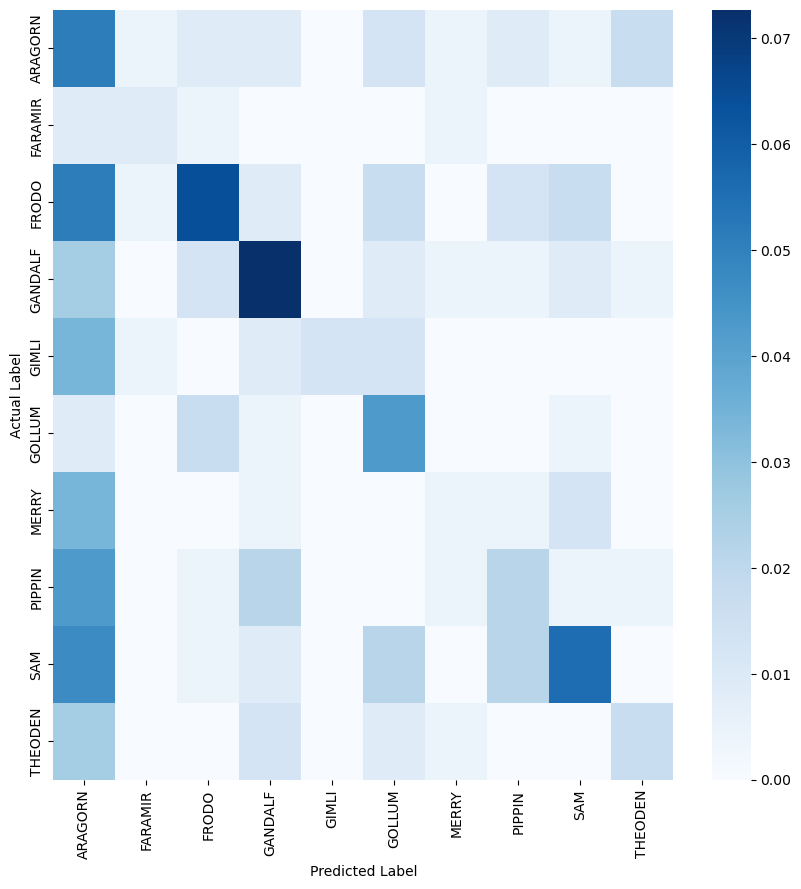

In [29]:
conf_matrix(P1, test_y)
plt.show()

<h3> 5.2 ANN

In [30]:
evaluate_model(P2, test_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         6
           2       0.19      0.85      0.30        41
           3       0.22      0.30      0.26        33
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        16

    accuracy                           0.19       234
   macro avg       0.04      0.12      0.06       234
weighted avg       0.06      0.19      0.09       234

Accuracy  0.1923
f1_score 0.0895
precision_score 0.0638
recall_score 0.1923


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

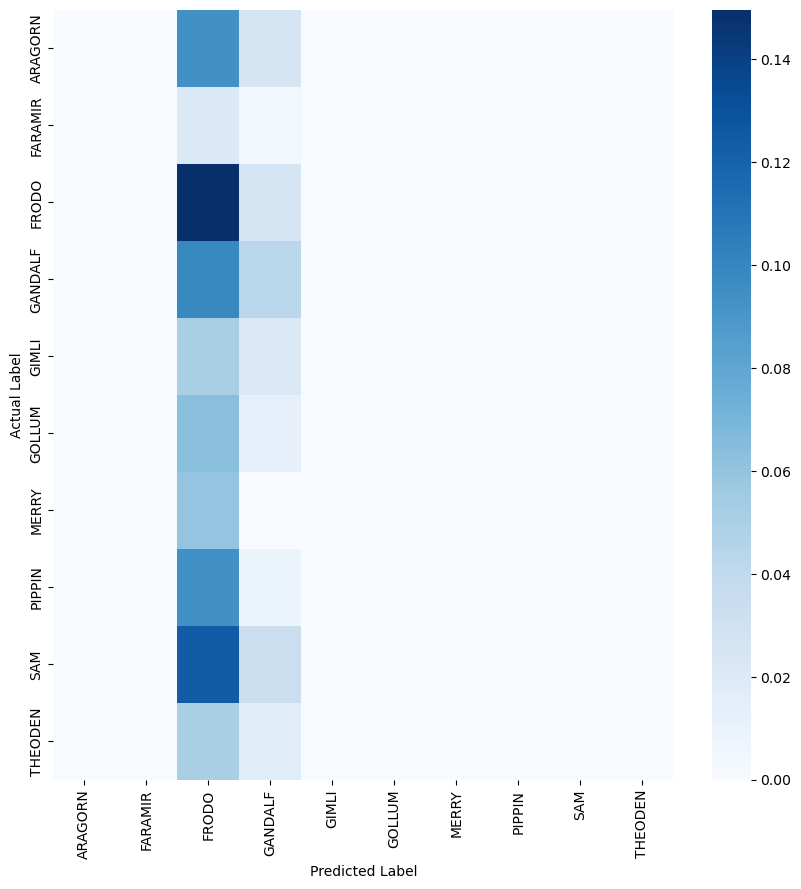

In [31]:
conf_matrix(P2, test_y)

<h3> 5.3 RFC

In [32]:
evaluate_model(P3, test_y)

              precision    recall  f1-score   support

           0       0.38      0.18      0.24        28
           1       0.00      0.00      0.00         6
           2       0.23      0.71      0.34        41
           3       0.54      0.42      0.47        33
           4       0.50      0.06      0.11        17
           5       0.50      0.56      0.53        18
           6       0.50      0.07      0.12        14
           7       0.62      0.21      0.31        24
           8       0.48      0.43      0.46        37
           9       1.00      0.12      0.22        16

    accuracy                           0.35       234
   macro avg       0.48      0.28      0.28       234
weighted avg       0.48      0.35      0.33       234

Accuracy  0.3547
f1_score 0.3314
precision_score 0.4755
recall_score 0.3547


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

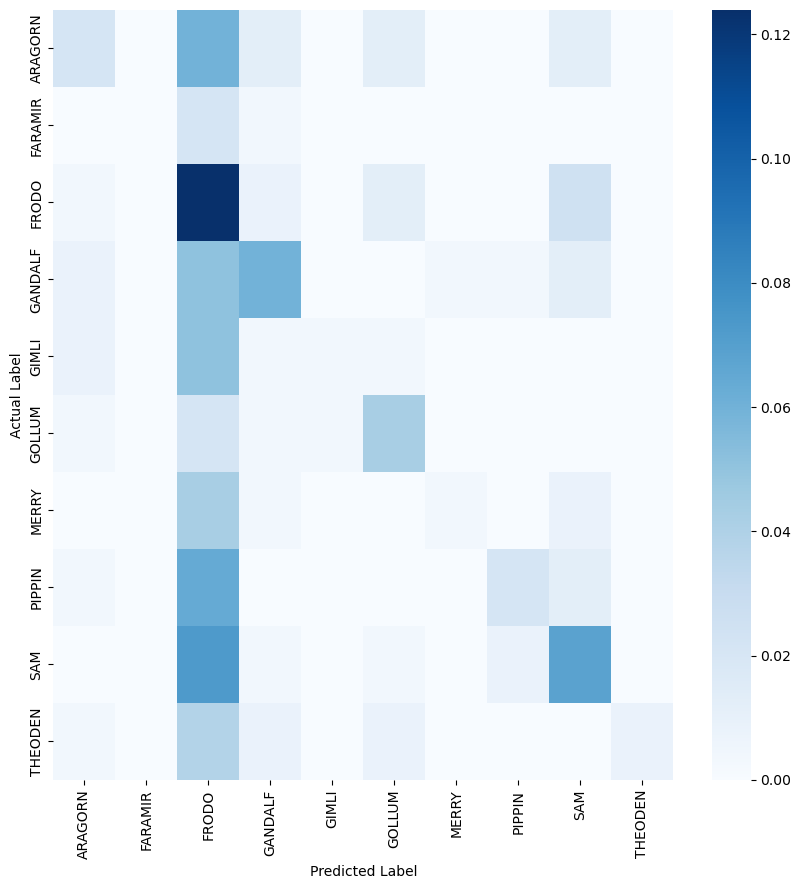

In [33]:
conf_matrix(P3, test_y)

<h3> 5.4 Ensemble


In [34]:
evaluate_model(final_preds, test_y)

              precision    recall  f1-score   support

           0       0.42      0.18      0.25        28
           1       0.00      0.00      0.00         6
           2       0.23      0.71      0.34        41
           3       0.47      0.45      0.46        33
           4       0.50      0.06      0.11        17
           5       0.47      0.50      0.49        18
           6       0.50      0.07      0.12        14
           7       0.71      0.21      0.32        24
           8       0.47      0.38      0.42        37
           9       1.00      0.12      0.22        16

    accuracy                           0.35       234
   macro avg       0.48      0.27      0.27       234
weighted avg       0.47      0.35      0.32       234

Accuracy  0.3462
f1_score 0.322
precision_score 0.4738
recall_score 0.3462


<Axes: xlabel='Predicted Label', ylabel='Actual Label'>

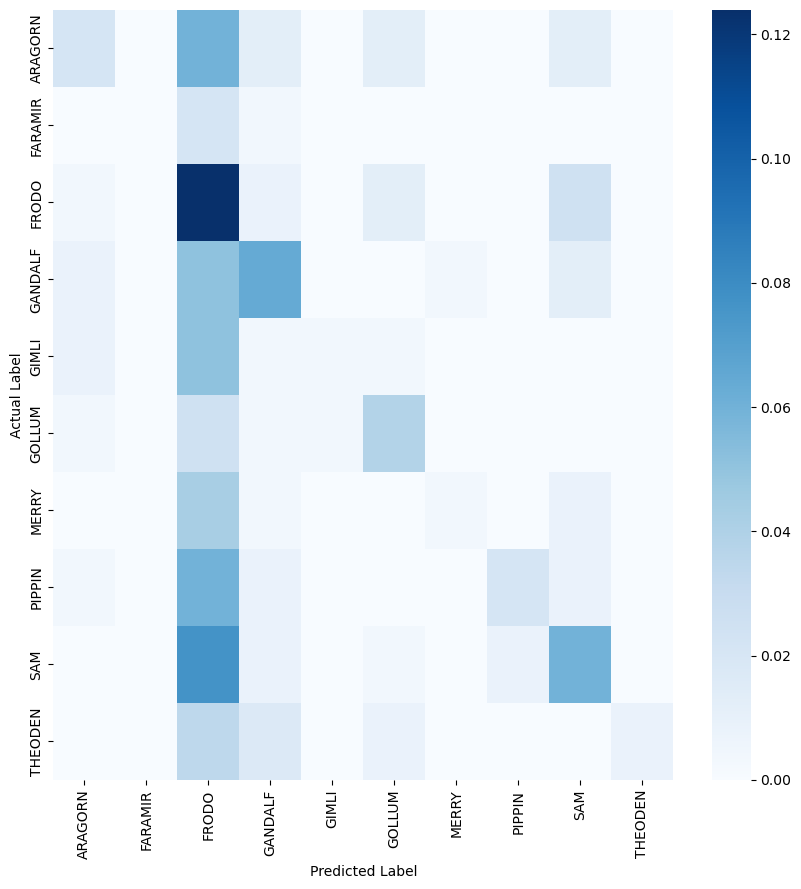

In [35]:
conf_matrix(final_preds, test_y)

<h2> 5.5 Naive Benchmark Majority Class

In [36]:
evaluate_model(test_y, np.repeat(2,len(final_preds)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.18      0.30       234
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.18       234
   macro avg       0.10      0.02      0.03       234
weighted avg       1.00      0.18      0.30       234

Accuracy  0.1752
f1_score 0.2982
precision_score 1.0
recall_score 0.1752
